In [5]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [6]:
# ============ 1. DEFINISI VARIABEL ============

# Input
distance = ctrl.Antecedent(np.arange(0, 151, 1), 'distance')   # meter
rel_speed = ctrl.Antecedent(np.arange(-40, 41, 1), 'rel_speed') # km/h
slope = ctrl.Antecedent(np.arange(-12, 13, 1), 'slope')         # derajat

# Output
accel = ctrl.Consequent(np.arange(-3, 2.1, 0.1), 'accel')       # m/s²

In [7]:
# ============ 2. MEMBERSHIP FUNCTIONS ============

# Distance
distance['very_close'] = fuzz.trapmf(distance.universe, [0, 0, 3, 8])
distance['close'] = fuzz.trimf(distance.universe, [5, 12, 20])
distance['safe'] = fuzz.trimf(distance.universe, [15, 30, 50])
distance['far'] = fuzz.trapmf(distance.universe, [40, 70, 150, 150])

# Relative Speed
rel_speed['opening_fast'] = fuzz.trapmf(rel_speed.universe, [-40, -40, -15, -8])
rel_speed['opening'] = fuzz.trimf(rel_speed.universe, [-12, -6, -1])
rel_speed['stable'] = fuzz.trimf(rel_speed.universe, [-2, 0, 2])
rel_speed['closing'] = fuzz.trimf(rel_speed.universe, [1, 6, 12])
rel_speed['closing_fast'] = fuzz.trapmf(rel_speed.universe, [8, 15, 40, 40])

# Slope
slope['downhill'] = fuzz.trapmf(slope.universe, [-12, -12, -6, -2])
slope['flat'] = fuzz.trimf(slope.universe, [-3, 0, 3])
slope['uphill'] = fuzz.trapmf(slope.universe, [1, 6, 12, 12])

# Acceleration
accel['strong_brake'] = fuzz.trapmf(accel.universe, [-3.0, -3.0, -2.2, -1.5])
accel['brake'] = fuzz.trimf(accel.universe, [-2.0, -1.2, -0.5])
accel['maintain'] = fuzz.trimf(accel.universe, [-0.8, 0.0, 0.8])
accel['accelerate'] = fuzz.trimf(accel.universe, [0.5, 1.2, 1.8])
accel['strong_accel'] = fuzz.trapmf(accel.universe, [1.5, 1.9, 2.0, 2.0])

In [8]:
# ============ 3. RULE BASE (≥9 aturan) ============

rule1  = ctrl.Rule(distance['very_close'] & rel_speed['closing_fast'], accel['strong_brake'])
rule2  = ctrl.Rule(distance['very_close'] & rel_speed['closing'], accel['brake'])
rule3  = ctrl.Rule(distance['close'] & rel_speed['closing'], accel['brake'])
rule4  = ctrl.Rule(distance['close'] & rel_speed['stable'], accel['maintain'])
rule5  = ctrl.Rule(distance['safe'] & rel_speed['opening'], accel['accelerate'])
rule6  = ctrl.Rule(distance['safe'] & rel_speed['opening_fast'], accel['strong_accel'])
rule7  = ctrl.Rule(distance['far'] & rel_speed['opening'], accel['accelerate'])
rule8  = ctrl.Rule(distance['safe'] & rel_speed['closing'], accel['maintain'])
rule9  = ctrl.Rule(slope['uphill'] & (distance['safe'] | distance['far']), accel['accelerate'])
rule10 = ctrl.Rule(slope['downhill'] & distance['close'], accel['brake'])
rule11 = ctrl.Rule(distance['very_close'] & slope['downhill'], accel['strong_brake'])
rule12 = ctrl.Rule(distance['safe'] & rel_speed['stable'], accel['maintain'])

Scenario 1: Distance=6m, ΔV=12km/h, Slope=0°
  -> Output Acceleration = -2.32 m/s²

Scenario 2: Distance=45m, ΔV=-10km/h, Slope=4°
  -> Output Acceleration = 1.29 m/s²

Scenario 3: Distance=30m, ΔV=3km/h, Slope=-5°
  -> Output Acceleration = 0.00 m/s²



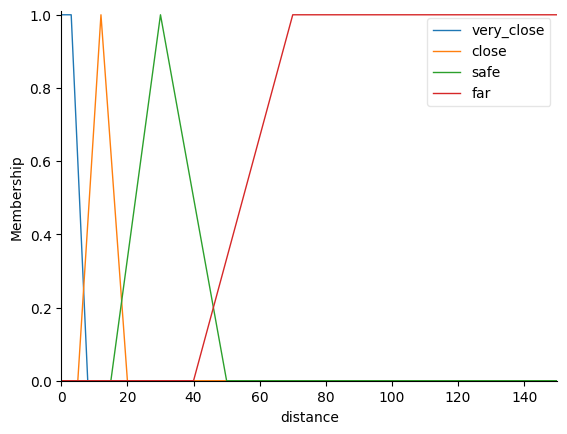

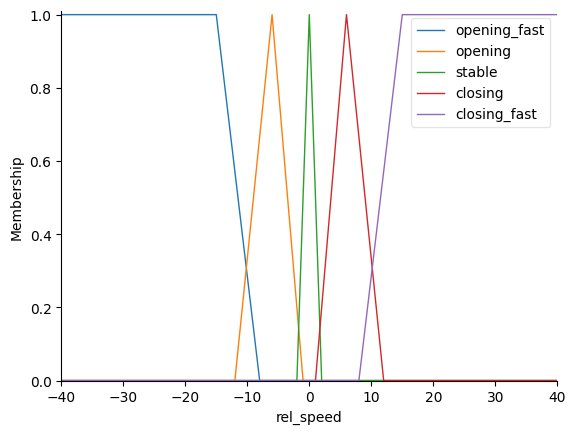

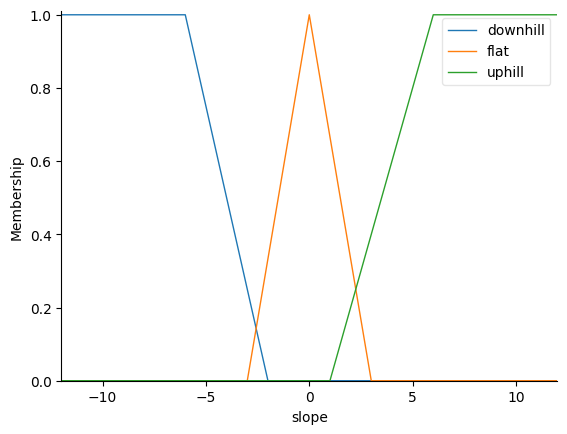

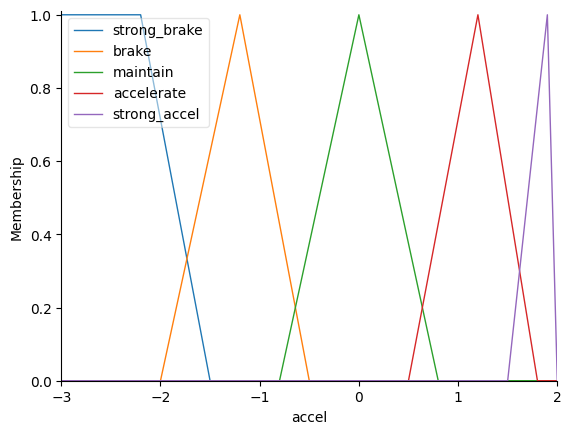

In [9]:
# ============ 4. SISTEM FUZZY ============

acc_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4, rule5, rule6,
    rule7, rule8, rule9, rule10, rule11, rule12
])
acc_sim = ctrl.ControlSystemSimulation(acc_ctrl)

# ============ 5. SIMULASI BEBERAPA SKENARIO ============

# Contoh skenario
scenarios = [
    {"D": 6, "V": 12, "S": 0},    # very close & closing fast
    {"D": 45, "V": -10, "S": 4},  # safe & opening & uphill
    {"D": 30, "V": 3, "S": -5},   # safe & closing & downhill
]

for i, s in enumerate(scenarios, 1):
    acc_sim.input['distance'] = s["D"]
    acc_sim.input['rel_speed'] = s["V"]
    acc_sim.input['slope'] = s["S"]
    acc_sim.compute()
    print(f"Scenario {i}: Distance={s['D']}m, ΔV={s['V']}km/h, Slope={s['S']}°")
    print(f"  -> Output Acceleration = {acc_sim.output['accel']:.2f} m/s²\n")

# ============ 6. VISUALISASI MEMBERSHIP (OPSIONAL) ============

distance.view()
rel_speed.view()
slope.view()
accel.view()
plt.show()
